## 1. Set Up Environment

#### The first step before running the code in this project is to set up the environment. In this section we will install the modules and import the libraries needed.

### 1.1. Installation of Modules

This part is where the necesarry modules needed in this project will be installed first to set the environment. (including the main ones, which are laspy and open3d)

In [1]:
# Modules/Libraries install
%pip install laspy
%pip install open3d
%pip install numpy
%pip install matplotlib
%pip install folium
%pip install plotly
%pip install pandas
%pip install pyproj
%pip install scikit-learn
%pip install trimesh

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### 1.2. Importing Libraries

In this part, all the libraries needed are imported. (some of the libraries are using alias such as open3d to o3d in order to simplify the code)

In [1]:
# Libraries importing
import laspy
import open3d as o3d
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import folium
import plotly.express as px
import pandas as pd
import pyproj
from sklearn.cluster import DBSCAN
import trimesh
import csv
import datetime
import json

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 2. LiDAR Data Preparation

#### The second step is to prepare the LiDAR data / LASer dataset that will be explored in this object. This section concist of importing the files and configure the dataset to fit the rest of the codes.

### 2.1. LiDAR Files Import

This cell concist of the input file reading and defining the las variable to read the .las file, which will be used for the rest of the workflow in this project. **input_file** will be the main LiDAR data that want to be explored, which in this case the .las dataset. User can flexibly change the **input_file** in this cell, and the rest of the code will follows the new data that has been inputed. **las** are used to define the LiDAR file reading using laspy and will be the base function in this project workflow.

In [3]:
# Specifying the LiDAR input file
input_file = "Dataset/34FN2_13.las" ## Change this to desired input data path

# Reading LAS file with laspy
las = laspy.read(input_file)

### 2.2. Data Configuration

This data configuration cell mainly include composing the base array to visualize the point cloud later on, as well as defining classes and functions such as **bounding_box_area** and **scalling** which derived from scale factors in order to rescale the unit of the dataset itself. Scalling factors in this step are important since its affecting the rescale step in most of the code. In this cell, the downsampling data are also defined in respective classes in order to reduce the computing power needed to run the code.

In [4]:
# Compossing base array
array_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1,0))

In [5]:
# Accessing scale factors and offsets for X, Y, and Z
scale_factors = las.header.scale
offsets = las.header.offset

# Extracting the elevation (z) offset
z_offset = offsets[2]

# Print commands
print(f"Z Offset: {z_offset}")
print(f"Complete Scale Factors: {scale_factors}")

Z Offset: 0.0
Complete Scale Factors: [0.001 0.001 0.001]


In [6]:
# Define the scalling
scaling = 0.001 ## Adjust based on the data scale factors

# Rescalled the elevation to unit (m)
corrected_elevation = array_data[:, 2] * scaling

In [7]:
# Make bounding box
def bounding_box_area(array_data):

    # Calculate and print the area of the bounding box, applying a scale factor to X and Y coordinates#
    
    # Apply scale factor to X and Y coordinates
    scaled_x = array_data[:, 0] * scaling
    scaled_y = array_data[:, 1] * scaling

    # Calculate min and max of scaled coordinates
    min_x, max_x = np.min(scaled_x), np.max(scaled_x)
    min_y, max_y = np.min(scaled_y), np.max(scaled_y)

    # Calculate the area using scaled coordinates
    area = (max_x - min_x) * (max_y - min_y)
    return area

# Call function
area = bounding_box_area(array_data)
print(f"Bounding Box Area: {area:.2f} square meters")

Bounding Box Area: 1341597.67 square meters


In [8]:
# Downsampling the data to reduce size
def downsample_data(array_data, sample_size=1000000): ## adjust sample size as needed

    # Randomly downsamples based on sample_size
    if len(array_data) > sample_size:
        indices = np.random.choice(len(array_data), size=sample_size, replace=False)
        return array_data[indices]
    return array_data

# Define class DS_data as downsampled array data
DS_data = downsample_data(array_data)

# Rescale the downsampled elevation
DS_elevation = DS_data[:, 2] * scaling

## 3. Data Information Overview

#### This third step is mainly to get an overview of the LiDAR data basic information such as number of points, header details, vlrs details, and the wkt information. This section will also explore the basic statistical information of the data.

### 3.1. Data Basic Information

This part will focus on showwing the basic information overview of the LiDAR data to further understand the data itself. Namely the information that can be extracted through the code in this cells are vlrs information, wkt information which is important to know the data geographical information, the format, classes, and other basic information. These informations therefore will also be used for in the rest of the project.

In [9]:
# Printing basic info of LAS File
def print_las_info():

    # Print header informations
    print("LAS Header:")
    print("File Version:", las.header.version)
    print("Point Format:", las.header.point_format)
    print("Number of Points:", las.header.point_count)

    # Print just sample points
    print("\nSample Points:")
    for i in range(min(5, las.header.point_count)):
        point = las.points[i]
        print(f"Point {i + 1}: ({point['X']}, {point['Y']}, {point['Z']})")

# Call function
print_las_info()

LAS Header:
File Version: 1.4
Point Format: <PointFormat(8, 6 bytes of extra dims)>
Number of Points: 28379820

Sample Points:
Point 1: (18400, 19960, 35556)
Point 2: (18814, 19848, 35560)
Point 3: (19190, 19746, 35554)
Point 4: (19551, 19648, 35557)
Point 5: (19955, 19539, 35592)


In [10]:
# Summarize point classifications
## Classification based on ASPRS where Generally, Class 1 represents unclassified points, Class 2 is ground, Class 6 is buildings, Class 9 is water, and Class 26 vary but mostly outlier
classifications = Counter(las.classification)

# Define class description
class_descriptions = {
    1: "Unclassified",
    2: "Ground",
    6: "Building",
    9: "Water",
    26: "Outlier"
}

# Print class result
print("Classification Overview:")
for class_value, count in classifications.items():
    description = class_descriptions.get(class_value, "Unknown")
    print(f"Class {class_value} ({description}): {count} points")
print()

Classification Overview:
Class 2 (Ground): 15371005 points
Class 1 (Unclassified): 6740413 points
Class 9 (Water): 7193 points
Class 6 (Building): 6225159 points
Class 26 (Outlier): 36050 points



In [11]:
# Extract Variable Length Records (VLRs)
vlrs = las.header.vlrs

# Grouping VLRs data by ID
vlr_groups = {}
for vlr in las.vlrs:
    if vlr.user_id not in vlr_groups:
        vlr_groups[vlr.user_id] = []
    vlr_groups[vlr.user_id].append(vlr)

# Iteration per VLRs and printing VLRs info
print("Variable Length Records (VLRs) Information:\n")
for idx, vlr in enumerate(las.vlrs, start=1):
    print(f"VLR #{idx}:")
    print(f"  User ID: {vlr.user_id}")
    print(f"  Detail: {vlr.description}")
    print(f"  Record ID: {vlr.record_id}")

Variable Length Records (VLRs) Information:

VLR #1:
  User ID: ESRI_Export
  Detail: Local Time: 2024 01 22 10 00 49
  Record ID: 5
VLR #2:
  User ID: ESRI_Export
  Detail: Local Time: 2024 01 22 10 00 44
  Record ID: 8
VLR #3:
  User ID: LASF_Spec
  Detail: Extra Bytes Record
  Record ID: 7
VLR #4:
  User ID: LASF_Spec
  Detail: RIEGL Extra Bytes
  Record ID: 4
VLR #5:
  User ID: LASF_Projection
  Detail: OGC Transformation Record
  Record ID: 2112
VLR #6:
  User ID: liblas
  Detail: OGR variant of OpenGIS WKT SRS
  Record ID: 2112


In [12]:
# Search for WKT geographical information from the VLR
for vlr in vlrs:
    if isinstance(vlr, laspy.vlrs.known.WktCoordinateSystemVlr):
        wkt = vlr.parse_crs()
        print("WKT Coordinate System:")
        print(wkt)

WKT Coordinate System:
COMPD_CS["Amersfoort / RD New + NAP height",PROJCS["Amersfoort / RD New",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","28992"]],VERT_CS["NAP height",VERT_DATUM["Normaal Amsterdams Peil",2005,AUTHORITY["EPSG","5109"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Gravity-related height",UP],AUTHORITY["EPSG","5709"]],AUTHORITY["EPSG","7415"]]


### 3.2. Data Statistics

In this part, the basic statistical information of the data are explored, including the plotting of the graph and the 2D elevation of the dataset. Matplotlib are used in this case mainly to plot the graph and the 2D version of the dataset. Elevation above sea level and ground elevation are extracted here for clearer differences.

In [13]:
# Extract Basic Statistics
def calculate_statistics(array_data):

    # Calculate the mean X, Y, and corrected Z values
    mean_x, mean_y = array_data[:, 0].mean(), array_data[:, 1].mean()
    mean_z = corrected_elevation.mean()

    # Calculate the median X, Y, and corrected Z values
    median_x, median_y = np.median(array_data[:, 0]), np.median(array_data[:, 1])
    median_z = np.median(corrected_elevation)

    # Calculate the distance between points using corrected Z values
    # First, replace the original Z values in array_data with corrected Z values for distance calculation
    corrected_array_data = np.copy(array_data)
    corrected_array_data[:, 2] = corrected_elevation
    distances = np.linalg.norm(np.diff(corrected_array_data, axis=0), axis=1)
    average_distance = distances.mean()  # Calculate the average distance

    # Print the statistics
    print(f"Mean X, Y, Z: {mean_x:.2f}, {mean_y:.2f}, {mean_z:.2f} ")
    print(f"Median X, Y, Z: {median_x:.2f}, {median_y:.2f}, {median_z:.2f} ")
    print(f"Average distance between points: {average_distance:.2f} m")

# Call function
calculate_statistics(array_data)

Mean X, Y, Z: 452490.55, 652203.24, 41.71 
Median X, Y, Z: 403546.00, 662061.00, 39.85 
Average distance between points: 1181.33 m


In [14]:
# Point density calculation
def calculate_point_density(array_data):
    
    # Calculate the density of points per square meter within the bounding box
    total_area = bounding_box_area(array_data)
    point_count = len(array_data)  # Using the total number of points in the dataset
    point_density = point_count / total_area  # Density per square meter
    return point_density

# Call function
density = calculate_point_density(array_data)
print(f"Point Density: {density:.2f} points / square meter")

Point Density: 21.15 points / square meter


In [15]:
# Extracting elevation above sea level statistics info of each point
def print_elevation_statistics(corrected_elevation):

    # Calculate statistics detail
    mean_elevation = np.mean(corrected_elevation)
    std_deviation = np.std(corrected_elevation)
    min_elevation = np.min(corrected_elevation)
    max_elevation = np.max(corrected_elevation)
    median_elevation = np.median(corrected_elevation)
    q1 = np.percentile(corrected_elevation, 25)
    q3 = np.percentile(corrected_elevation, 75)
    iqr = q3 - q1
    cv = std_deviation / mean_elevation if mean_elevation else 0  ## Avoid Zero since its division

    # Print each information commands
    print(f"Mean elevation: {mean_elevation:.2f} m")
    print(f"Standard deviation of elevation: {std_deviation:.2f} m")
    print(f"Minimum elevation: {min_elevation:.2f} m")
    print(f"Maximum elevation: {max_elevation:.2f} m")
    print(f"Median elevation: {median_elevation:.2f} m")
    print(f"25th percentile elevation: {q1:.2f} m")
    print(f"75th percentile elevation: {q3:.2f} m")
    print(f"IQR of elevation: {iqr:.2f} m")
    print(f"Coefficient of variation of elevation: {cv:.2f}")

# Call function
print_elevation_statistics(corrected_elevation)

Mean elevation: 41.71 m
Standard deviation of elevation: 6.14 m
Minimum elevation: 33.54 m
Maximum elevation: 87.25 m
Median elevation: 39.85 m
25th percentile elevation: 37.13 m
75th percentile elevation: 44.55 m
IQR of elevation: 7.43 m
Coefficient of variation of elevation: 0.15


In [16]:
# Extracting ground level statistics info of each point
def print_ground_level_statistics(corrected_elevation):

    # Assume ground points are within the lowest 10th percentile to filter out elevated structures
    ground_threshold = np.percentile(corrected_elevation, 10)  # Adjust this percentile based on dataset
    ground_points = corrected_elevation[corrected_elevation <= ground_threshold]
    
    # Calculate statistics for assumed ground points
    mean_ground_elevation = np.mean(ground_points)
    min_ground_elevation = np.min(ground_points)
    max_ground_elevation = np.max(ground_points)
    median_ground_elevation = np.median(ground_points)
    
    # Print statistics
    print(f"Mean ground elevation: {mean_ground_elevation:.2f} m")
    print(f"Minimum ground elevation: {min_ground_elevation:.2f} m")
    print(f"Maximum ground elevation: {max_ground_elevation:.2f} m")
    print(f"Median ground elevation: {median_ground_elevation:.2f} m")

# Call function assuming that corrected_elevation already scaled
print_ground_level_statistics(corrected_elevation)

Mean ground elevation: 35.60 m
Minimum ground elevation: 33.54 m
Maximum ground elevation: 35.97 m
Median ground elevation: 35.65 m


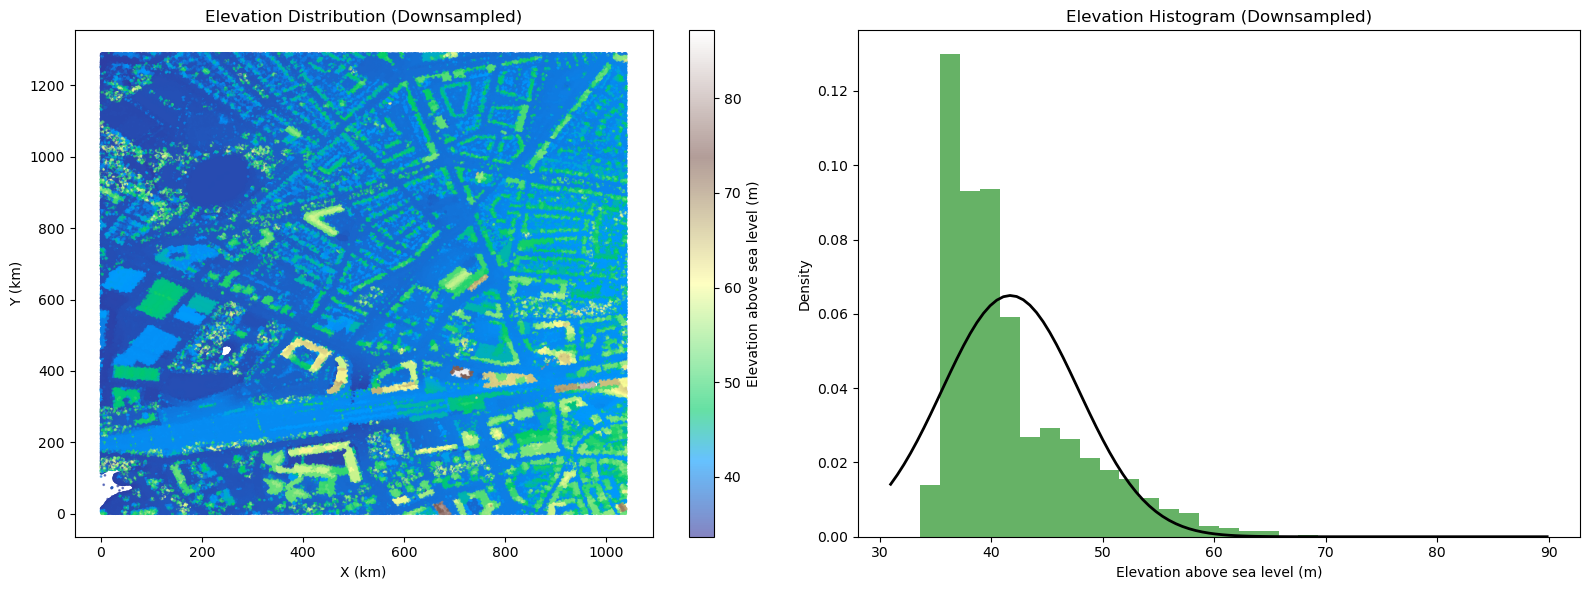

In [17]:
# Plotting the overall dataset into histogram and elevation plot
## (%matplotlib inline) is used to show the result in the jupyter notebook line
%matplotlib inline 

# Define the elevation distributaion and histogram plot
## Using downsample array data to minimize the processing time
def plot_overall(DS_data):

    #Combine 2 different plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Elevation Distribution Plot
    sc = ax[0].scatter(DS_data[:, 0] * scaling, DS_data[:, 1] * scaling, c=DS_elevation, cmap='terrain', s=1, alpha=0.6)
    fig.colorbar(sc, ax=ax[0], label='Elevation above sea level (m)')
    ax[0].set_xlabel('X (km)')
    ax[0].set_ylabel('Y (km)')
    ax[0].set_title('Elevation Distribution (Downsampled)')
    
    # Elevation Histogram with Fit
    mu, std = norm.fit(DS_elevation)
    ax[1].hist(DS_elevation, bins=30, density=True, alpha=0.6, color='g')
    xmin, xmax = ax[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title('Elevation Histogram (Downsampled)')
    ax[1].set_xlabel('Elevation above sea level (m)')
    ax[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

#Call function
plot_overall(DS_data)

In [18]:
# Filtering assumed building only point cloud from the overall dataset
## This cell identified the assumed 10th percentile as the base to get the ground point information
percentile_10th = np.percentile(DS_elevation, 10) # Meters -> adopted from the ground elevation statistics info, need to be adjusted based on the dataset
ground_points_indices = np.where(DS_elevation <= percentile_10th)[0]

# Elevation adjusted based on the min ground elevation
min_ground_elevation = np.min(DS_elevation[ground_points_indices])
adjusted_elevation = DS_elevation - min_ground_elevation

# Identifying building points in the LAS dataset
building_threshold = 10  # Meters above the "ground"
building_indices = np.where(adjusted_elevation >= building_threshold)[0]
building_points = DS_data[building_indices, :3]  # Extract building points based on adjusted elevation

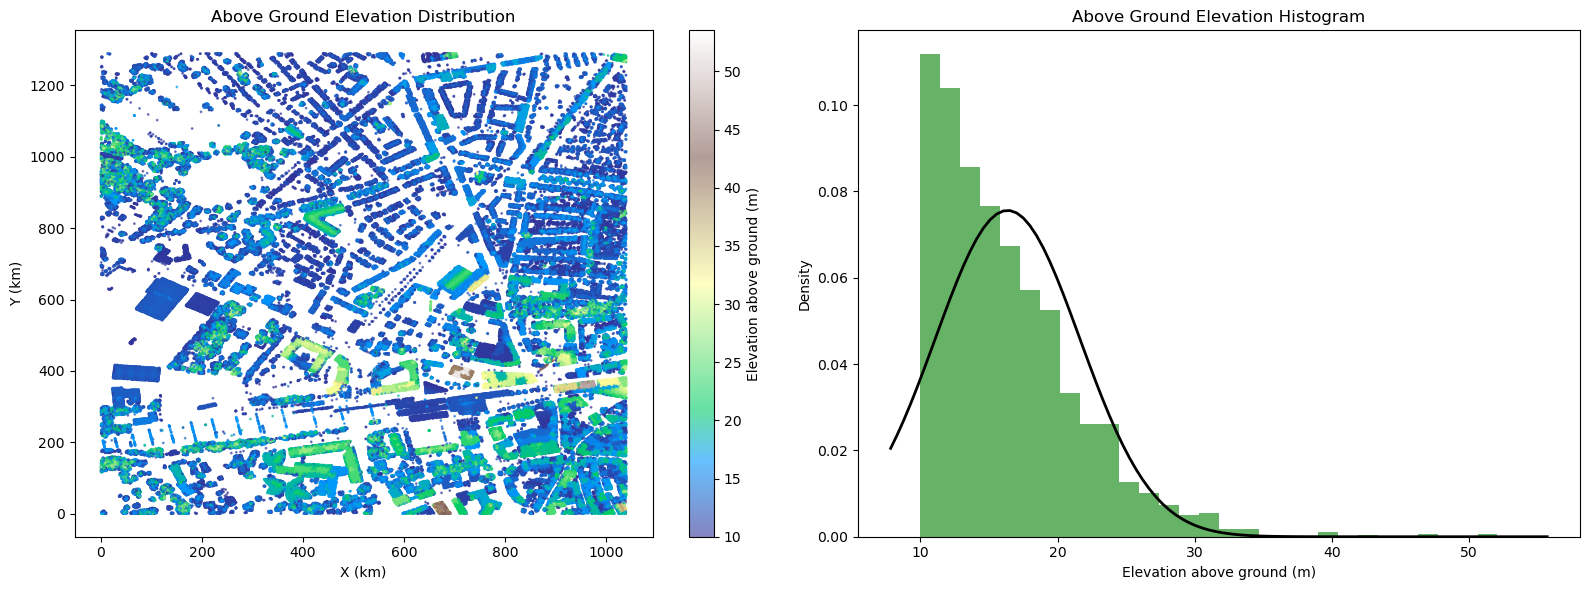

In [19]:
# Plotting the building only dataset into histogram and elevation plot
## (%matplotlib inline) is used to show the result in the jupyter notebook line
%matplotlib inline 

# Define the building only elevation distributaion and histogram plot
## Using downsample array data to minimize the processing time
def plot_building(DS_data, DS_elevation, ground_points_indices, building_indices):
    
    # Adjusted elevation for buildings based on building indices and ground point indices
    building_elevation = DS_elevation[building_indices] - np.min(DS_elevation[ground_points_indices])
    
    #Combine 2 different plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Elevation Distribution Plot for Buildings
    sc = ax[0].scatter(DS_data[building_indices, 0] * scaling, DS_data[building_indices, 1] * scaling, c=building_elevation, cmap='terrain', s=1, alpha=0.6)
    fig.colorbar(sc, ax=ax[0], label='Elevation above ground (m)')
    ax[0].set_xlabel('X (km)')
    ax[0].set_ylabel('Y (km)')
    ax[0].set_title('Above Ground Elevation Distribution')
    
    # Elevation Histogram with Fit for Buildings
    mu, std = norm.fit(building_elevation)
    ax[1].hist(building_elevation, bins=30, density=True, alpha=0.6, color='g')
    xmin, xmax = ax[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title('Above Ground Elevation Histogram')
    ax[1].set_xlabel('Elevation above ground (m)')
    ax[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Call function
plot_building(DS_data, DS_elevation, ground_points_indices, building_indices)


## 4. Data Visualisation Overview

#### In the fourth step, we will delve into open3d exploration, where the overall array are explored and visualized. Building only points will also be visualized here to see the differences. The points are also plotted in 3D axes to see the distribution in a 3D space.

In [20]:
# Assigned base geom variable with overall array_data
## this overall point clouds array_data are heavy to load might take few seconds
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(array_data)

# Visualizing in Open3D
o3d.visualization.draw_geometries([geom], "Interactive Visualization")

In [21]:
# Assigned base geom variable with downsampled data
## this downsampled data is faster to process and will show right away
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(DS_data)

# Visualizing in Open3D
o3d.visualization.draw_geometries([geom], "Interactive Visualization")

In [22]:
# Convert building points to Open3D point cloud for visualization
## Define variables point clouds (pcd) only for the assumed buildings (this work the same with geom)
pcd_buildings = o3d.geometry.PointCloud()
pcd_buildings.points = o3d.utility.Vector3dVector(building_points)

# Estimate normals for a better visualization
pcd_buildings.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30)) #radius can be tuned as needed

# Visualize in Open3D
o3d.visualization.draw_geometries([pcd_buildings], window_name="Building Surface Visualization")

In [23]:
## pcd_buildings still quite heavy, so in this part we define new variable for only the high building with minimum height of 20m above ground
# Define new base ground level for the high_building
base_ground_level = np.mean(DS_elevation[ground_points_indices])

# Set up the height assumed and the treshold
high_building_height = 20  # Meters above ground level -> adjust based on the statistics result or assumption
high_building_treshold = base_ground_level + high_building_height

# Find indices of high building points above the threshold
high_building_indices = np.where(DS_elevation > high_building_treshold)[0]

In [24]:
# Extract high building points based on identified indices
high_building = DS_data[high_building_indices, :3]  # array should contain xyz data for this to work, so check again if it didn't work

# Create a point cloud object for the high building points
pcd_high_buildings = o3d.geometry.PointCloud()
pcd_high_buildings.points = o3d.utility.Vector3dVector(high_building)

# Estimate normals for this subset for better visualization
pcd_high_buildings.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30))

# Visualize in Open3D
o3d.visualization.draw_geometries([pcd_high_buildings], window_name="High Buildings Visualization")

In [25]:
# Plotting the high building point clouds object in matplotlib 3D to see the distribution in 3D space
## (%matplotlib qt5) is used to show the result in new pop up window
%matplotlib qt5


# Apply the scale factor to convert coordinates to meters
x = high_building[:, 0] * scaling  # Scaling X coordinates
y = high_building[:, 1] * scaling  # Scaling Y coordinates
z = high_building[:, 2] * scaling  # Scaling Z coordinates (elevation)

# Create a new matplotlib figure and 3D axis
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the building points, color-coded by elevation
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='.', s=1, alpha=0.6)

# Adding a color bar to indicate elevation
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Elevation (m)')

# Setting axis labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Elevation (m)')

# Set title
ax.set_title('Buildings Above 20m Plotting')

# Show plot
plt.show()

## 5. Voxelization

#### This fifth step will focus on how to further explore the las dataset visualization potential. In this case, voxelization is explored to get better form of the building point cloud and eventually transform it into meshes complete with faces and vertices.

In [30]:
## Before voxelization, clustering is done to see how many cluster is there in the pcd_high_buildings
# Convert only high building point cloud to NumPy array
pcd_np = np.asarray(pcd_high_buildings.points)

# Perform DBSCAN clustering
epsilon = 50000  # Adjust based on your data scale, this number seems high because of the data rescalling. Different classes will be generated depending on the epsilon value.
min_cluster_points = 10  # Minimum cluster size
dbscan_clustering = DBSCAN(eps=epsilon, min_samples=min_cluster_points).fit(pcd_np)
labels = dbscan_clustering.labels_

# Print number of clusters
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Point cloud has {n_clusters} clusters")

Point cloud has 26 clusters


In [31]:
## Assign spesific colors based on the cluster for each points in pcd_high_buildings
# Assign unique labels based on the DBSCAN labels clustering
unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)  # Exclude noise labels

# Generate a color for each cluster
colors = plt.get_cmap("tab20")(np.linspace(0, 1, n_clusters))

# Pre-allocate an array for point colors with the correct shape and dtype
point_colors = np.zeros((len(labels), 3), dtype=np.float64)

# Mapping each point to its cluster color
for i, label in enumerate(labels):
    if label >= 0:
        color_idx = label % len(colors)  # Use modulo operation to avoid index out of bounds
        point_colors[i] = colors[color_idx][:3]  # Exclude possible alpha channel
    else:
        point_colors[i] = [0.5, 0.5, 0.5]  # Gray color for noise points

# Assign colors to high building point cloud
pcd_high_buildings.colors = o3d.utility.Vector3dVector(point_colors)

# Visualize the colored point cloud in Open3D
o3d.visualization.draw_geometries([pcd_high_buildings], "Clustered Point Cloud")

In [32]:
# Basic voxelization for the pcd_high_buildings, only voxelized the recorded point clouds
## This part is to check the approximate voxel size for this dataset
base_voxel_size = 2800.0  # Choose an appropriate voxel size, change it as it fits, until the voxel are visible in the window (normally it should not be this high, but the scalling affect the voxel size points)
base_voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_high_buildings, base_voxel_size) # Create the base grid

# Visualize the base voxel grid
o3d.visualization.draw_geometries([base_voxel_grid], window_name="Voxelized High Buildings Visualization")

In [33]:
## Voxel for the top of the object was created, this step further explore the voxelization method to obtain the side faces of the object body
# Estimate normals to get a lines drawn from point clouds
pcd_high_buildings.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=2, max_nn=30))

# Create tangent plane as the extrude plane of the lines
pcd_high_buildings.orient_normals_consistent_tangent_plane(50)

# Define variable for points and normals of the pcd
points = np.asarray(pcd_high_buildings.points)
normals = np.asarray(pcd_high_buildings.normals)

# Compute the end points of lines at the base ground level
end_points = np.copy(points)
end_points[:, 2] = base_ground_level  # Adjust elevation to base ground level

# Create line set from points to their projected base ground level (tangent plane)
lines = [[i, i + len(points)] for i in range(len(points))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.vstack((points, end_points))),
    lines=o3d.utility.Vector2iVector(lines),
)

# Visualize the line set with original pcd of high buildings
o3d.visualization.draw_geometries([pcd_high_buildings, line_set], "PCD with Lines to Ground")

In [34]:
# Define function to get sample points along the normal lines, this is done so that the line can be voxelized
def line_sample_points(start_points, end_points, colors, num_samples=10):
    sampled_points = []
    sampled_colors = []
    for start, end, color in zip(start_points, end_points, colors):
        for t in np.linspace(0, 1, num_samples):
            sampled_point = start * (1 - t) + end * t
            sampled_points.append(sampled_point)
            sampled_colors.append(color)  # Use the same color as the start point
    return np.array(sampled_points), np.array(sampled_colors)

# Call function to sample points and colors along the lines
sampled_line_points, sampled_line_colors = line_sample_points(points, end_points, point_colors, num_samples=10)

# Combine the original points with the sampled line points
combined_points = np.vstack((points, sampled_line_points))

# Combine the original colors with the sampled line colors
combined_colors = np.vstack((point_colors, sampled_line_colors))

In [35]:
# Create a PointCloud object from the combined points and colors
combined_pcd = o3d.geometry.PointCloud()
combined_pcd.points = o3d.utility.Vector3dVector(combined_points)
combined_pcd.colors = o3d.utility.Vector3dVector(combined_colors)

# Voxelize the combined point cloud of high building
voxel_size = 6000  # Adjust until the voxel are appropriate and vissible
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(combined_pcd, voxel_size)

# Visualize the voxel grid that contain the object faces from voxelization
o3d.visualization.draw_geometries([voxel_grid], "Combined Point Cloud with Colors")

In [36]:
# Define variables for points and normals of the combined voxels
voxel_points = np.asarray(combined_pcd.points)

# Cluster back the voxel, to estimate the number of voxels cluster, this will be used to assign meshes as unique object
clustering = DBSCAN(eps=8000, min_samples=10).fit(voxel_points)  # Adjust epsilon and min_samples based on the data
labels = clustering.labels_

# Call the number of voxel clusters
voxel_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Estimated number of clusters: {voxel_clusters}')

Estimated number of clusters: 212


In [37]:
# Create the meshes place holder based on the clusters
cluster_meshes = []

# Create cluster_id to make each meshes unique object
for cluster_id in range(voxel_clusters):
    # Extract points belonging to the current cluster, excluding noise
    cluster_points = voxel_points[labels == cluster_id]
    
    # Check if enough points present for a convex hull
    if len(cluster_points) >= 4:
        hull = trimesh.convex.convex_hull(trimesh.Trimesh(vertices=cluster_points))
        cluster_meshes.append(hull)
        
# Visualize the mesh result in Open3D
o3d_meshes = [o3d.geometry.TriangleMesh(vertices=o3d.utility.Vector3dVector(mesh.vertices), triangles=o3d.utility.Vector3iVector(mesh.faces)) for mesh in cluster_meshes]
o3d.visualization.draw_geometries(o3d_meshes)

In [38]:
## This step will saved the meshes result into .ply so it can be used in another software
# Placeholder for list of TriangleMesh objects from Open3D
combined_vertices = []
combined_triangles = []
current_vertex_count = 0

# Redefine mesh variable
for mesh in o3d_meshes:

    # Get vertices and triangles from the current mesh
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles) + current_vertex_count  # Update triangle indices
    
    # Append to the combined lists
    combined_vertices.append(vertices)
    combined_triangles.append(triangles)
    
    # Update the count of vertices
    current_vertex_count += len(vertices)

# Fuse all vertices and triangles to form the combined mesh
combined_vertices = np.vstack(combined_vertices)
combined_triangles = np.vstack(combined_triangles)

# Create a new TriangleMesh object for the combined mesh
combined_mesh = o3d.geometry.TriangleMesh()
combined_mesh.vertices = o3d.utility.Vector3dVector(combined_vertices)
combined_mesh.triangles = o3d.utility.Vector3iVector(combined_triangles)

# Compute normals for the combined mesh
combined_mesh.compute_vertex_normals()

# Save the combined mesh to a .ply file
o3d.io.write_triangle_mesh("combined_mesh.ply", combined_mesh)

# Print for successful saved data
print("Saved combined mesh to 'combined_mesh.ply'")

Saved combined mesh to 'combined_mesh.ply'


In [39]:
## Check the saved .ply file in Open3D
# Load the mesh
combined_mesh = o3d.io.read_triangle_mesh("combined_mesh.ply")

# Compute normals for better visualization
combined_mesh.compute_vertex_normals()

# Visualize mesh in Open3D
o3d.visualization.draw_geometries([combined_mesh])

In [ ]:
## OPTIONAL step, this can save each individual uniqe meshes into separate .ply file
# Saving meshes individually
for i, mesh in enumerate(cluster_meshes):
    mesh.export(f'cluster_mesh_{i}.ply') 

## 6. Local Coordinate Transformation & Extraction

#### Sixth step will explore the way to extract the coordinate or geographical information of LiDAR point cloud. Some LiDAR dataset only have local coordinate which is not compatibel with real world crs, therefore the transformation method will also be done in this section.

In [40]:
## Finding the cartesian coordinates or local coordinates from LiDAR point clouds
# Extract Cartesian coordinates
coordinates = las.xyz

# Create a DataFrame with individual rows for each point
df = pd.DataFrame({'X': coordinates[:, 0], 'Y': coordinates[:, 1], 'Z': coordinates[:, 2]})

# Display the first 5 DataFrame
df.head()

,X,Y,Z
0,256998.400,471249.960,35.556
1,256998.814,471249.848,35.560
2,256999.190,471249.746,35.554
3,256999.551,471249.648,35.557
4,256999.955,471249.539,35.592


In [41]:
## In this part, its important to know the WKT detail, therefore the wkt was printed in data info extraction stage

# Convert xyz of the objects to NumPy arrays
x_coordinates = coordinates[:, 0]
y_coordinates = coordinates[:, 1]
z_coordinates = coordinates[:, 2]

# Define the CRS of the LAS data as Amersfoort / RD New (EPSG:28992)
source_crs = pyproj.CRS("EPSG:28992")

# Define the target CRS as WGS84 (EPSG:4326)
target_crs = pyproj.CRS("EPSG:4326")

# Create a Transformer to convert from EPSG:28992 to EPSG:4326
## Note: always_xy=True ensures the transformer expects (x, y) order in inputs and outputs.
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# Transform Cartesian coordinates (x, y) to geographic coordinates (longitude, latitude)
lon, lat = transformer.transform(x_coordinates, y_coordinates)

# Create a DataFrame with the transformed coordinates
df_geo = pd.DataFrame({
    'Longitude': lon,
    'Latitude': lat,
    'Z': z_coordinates
})

# Display the long lat of the first 5 DataFrame
df_geo.head()

,Longitude,Latitude,Z
0,6.879902,52.219885,35.556
1,6.879908,52.219884,35.560
2,6.879914,52.219883,35.554
3,6.879919,52.219882,35.557
4,6.879925,52.219881,35.592


In [43]:
# Showing the point clouds with transformed coordinates in folium map to check the acuracy
df_sample = df_geo.head(50)  # Take the first 50 points as sample, the bigger it is the heavier the map to load

# Calculate the center of the points for the initial map view
center_lat = df_sample['Latitude'].mean()
center_lon = df_sample['Longitude'].mean()

# Create a folium map centered around these points
map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add markers for each point
for index, row in df_sample.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Z: {row['Z']}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(map)

# Display the map
map

In [44]:
## Alternative check with scatter mapbox plotly express, this libraries allow us to plot the points along with the details of elevation in the colorbar
# Assign the Z value as altitude from the sample point
df_sample.rename(columns={'Altitude': 'Z'}, inplace=True)

# Create a scatter mapbox plot using Plotly Express
fig = px.scatter_mapbox(df_sample, lat='Latitude', lon='Longitude', 
                        color='Z', size='Z',
                        mapbox_style='open-street-map',
                        zoom=10, title='Point Cloud on Map')

# Configure color bar title
fig.update_layout(coloraxis_colorbar=dict(
    title='Elevation (m) <br>&nbsp;',
    tickformat='.2f'
))

# Display the map plot
fig.show()

C:\Users\ikram\AppData\Local\Temp\ipykernel_35240\2195398232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.rename(columns={'Altitude': 'Z'}, inplace=True)


In [45]:
# Saving the transformed coordinates DataFrame to CSV format
df_geo.to_csv('geographic_coordinates.csv', index=False)

# Get the current date and time
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Add a timestamp to the file
with open('geographic_coordinates.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Exported at:', current_datetime])

# Print function
print("DataFrame saved to 'geographic_coordinates.csv' with timestamp:", current_datetime)

DataFrame saved to 'geographic_coordinates.csv' with timestamp: 2024-02-19 13:43:29


In [46]:
# Saving the transformed coordinates DataFrame to JSON format
df_geo.to_json('geographic_coordinates.json', orient='records')

# Get the current date and time
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Add a timestamp to the JSON file
with open('geographic_coordinates.json', 'a') as file:
    json.dump({"Exported at": current_datetime}, file, indent=4)

# Print function
print("DataFrame saved to 'geographic_coordinates.json' with timestamp:", current_datetime)

DataFrame saved to 'geographic_coordinates.json' with timestamp: 2024-02-19 13:43:51
